Taking `examples/examples.ipynb` as a starting point.  

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("..")
sys.path.append("../..")

import numpy as np 
import pandas as pd
import yellowbrick as yb

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# from yellowbrick.features import 

### Dataset

In [4]:
from download import download_all 

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "credit": os.path.join(FIXTURES, "credit", "credit.csv"),
    "concrete": os.path.join(FIXTURES, "concrete", "concrete.csv"),
    "occupancy": os.path.join(FIXTURES, "occupancy", "occupancy.csv"),
    "mushroom": os.path.join(FIXTURES, "mushroom", "mushroom.csv"),
}

def load_data(name, download=True):
    """
    Loads and wrangles the passed in dataset by name.
    If download is specified, this method will download any missing files. 
    """
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
    
    # Return the data frame
    return pd.read_csv(path)

In [5]:
# Load the classification data set
data = load_data('occupancy') 
print(len(data))
data.head()

20560


,datetime,temperature,relative humidity,light,C02,humidity,occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [6]:
# Specify the features of interest and the classes of the target 
features = ["temperature", "relative humidity", "light", "C02", "humidity"]
classes = ['unoccupied', 'occupied']

# Extract the numpy arrays from the data frame 
X = data[features]
y = data.occupancy

### Grid search base

Doesn't draw anything, just gets scores over the grid. 

In [7]:
#Vanilla grid search
svc = SVC()
grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
clf = GridSearchCV(svc, grid, n_jobs=4)

In [8]:
# %%time
# clf.fit(X.head(1000), y.head(1000))

In [9]:
# clf.best_params_

In [10]:
# clf.cv_results_

In [11]:
# clf.grid_scores_

In [12]:
# from yellowbrick.gridsearch.base import param_projection

In [13]:
# param_1 = 'C'
# param_2 = 'kernel'
# param_projection(clf.cv_results_, (param_1, param_2))

In [14]:
from yellowbrick.gridsearch.pcolor import GridSearchColorPlot

{'gamma': masked}


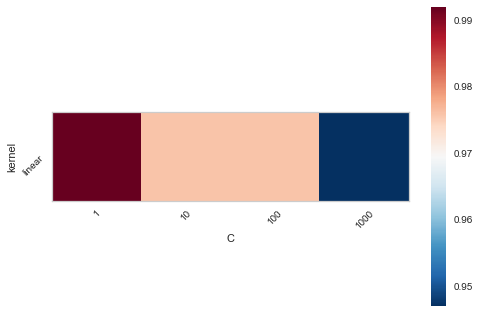

In [15]:
gsv = GridSearchColorPlot(clf, 'C', 'kernel')
gsv.fit(X.head(1000), y.head(1000)).poof()